<h1 style="font-family:verdana;"> <center>Brain Tumor Detection using Tensorflow CNN</center> </h1>

# Importing Libraries

In [24]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

# Data Loading

In [25]:
os.listdir('./data')

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [26]:
classes_tumor = {'glioma_tumor': 'glioma_tumor',
 'meningioma_tumor': 'meningioma_tumor',
 'no_tumor': 'no_tumor',
 'pituitary_tumor': 'pituitary_tumor'}

for key, value in classes_tumor.items():
    source_path = f"./data/{value}"
    print(f"There are {len(os.listdir(source_path))} images of {value}")

There are 926 images of glioma_tumor
There are 937 images of meningioma_tumor
There are 500 images of no_tumor
There are 901 images of pituitary_tumor


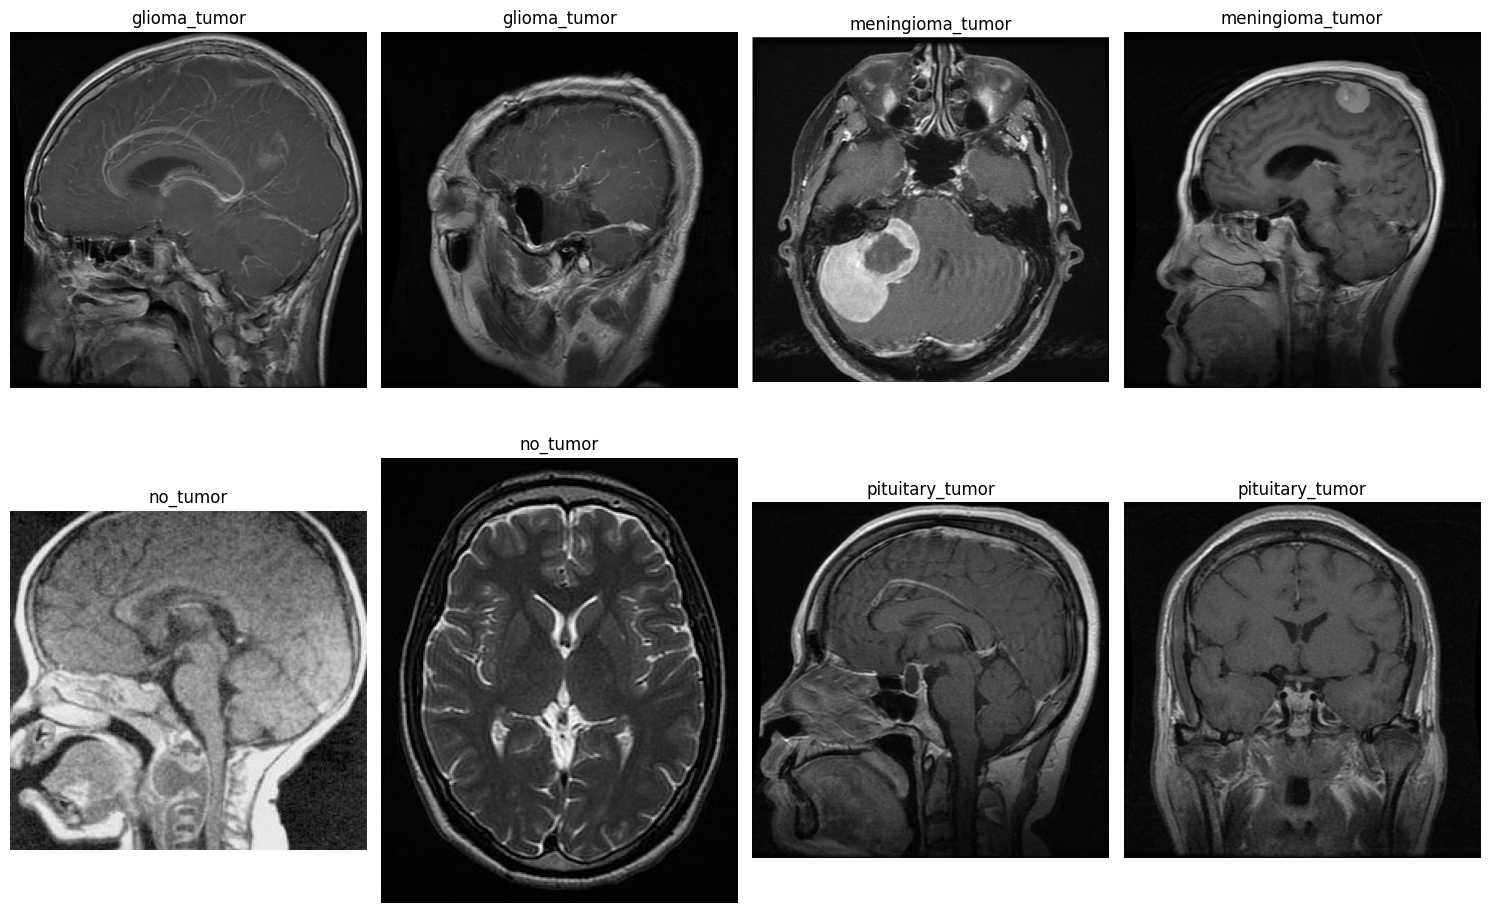

In [27]:
import random

def show_images_from_classes(classes_tumor, data_path="./data"):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))  # 4 rows, 2 columns

    # Flatten the axes for easier indexing
    ax = ax.flatten()

    # Display 2 images for each class
    idx = 0
    for value in classes_tumor.values():
        source_path = os.path.join(data_path, value)
        image_files = os.listdir(source_path)

        # Select 2 random images from the class
        selected_images = random.sample(image_files, 2)
        
        for i, img_file in enumerate(selected_images):
            image_path = os.path.join(source_path, img_file)
            image = plt.imread(image_path)
            ax[idx].imshow(image)
            ax[idx].set_title(f"{value}")
            ax[idx].axis('off')  # Hide axes for better display
            idx += 1

    plt.tight_layout()
    plt.show()

show_images_from_classes(classes_tumor)

In [28]:
# Define labels and image size
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
label_to_index = {label: idx for idx, label in enumerate(labels)}
image_size = 128

# Initialize lists for images and labels
X_data = []
y_data = []

# Load images from './data' folder
for label in labels:
    folderPath = os.path.join('./data', label)
    for filename in tqdm(os.listdir(folderPath), desc=f"Loading {label} images"):
        img = cv2.imread(os.path.join(folderPath, filename))
        img = cv2.resize(img, (image_size, image_size))
        X_data.append(img)
        y_data.append(label_to_index[label])  # Use numeric label

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# Split the data into 80% training and 20% remaining (which we will split further)
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# Split the remaining 20% into 10% validation and 10% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(labels))
y_val = to_categorical(y_val, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

# Check the sizes of each dataset
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Loading pituitary_tumor images: 100%|██████████| 901/901 [00:02<00:00, 337.42it/s]


Training data shape: (2611, 128, 128, 3), Labels shape: (2611, 4)
Validation data shape: (326, 128, 128, 3), Labels shape: (326, 4)
Testing data shape: (327, 128, 128, 3), Labels shape: (327, 4)


# Data augmentation

In [29]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False, 
    fill_mode='nearest')

datagen.fit(X_train)

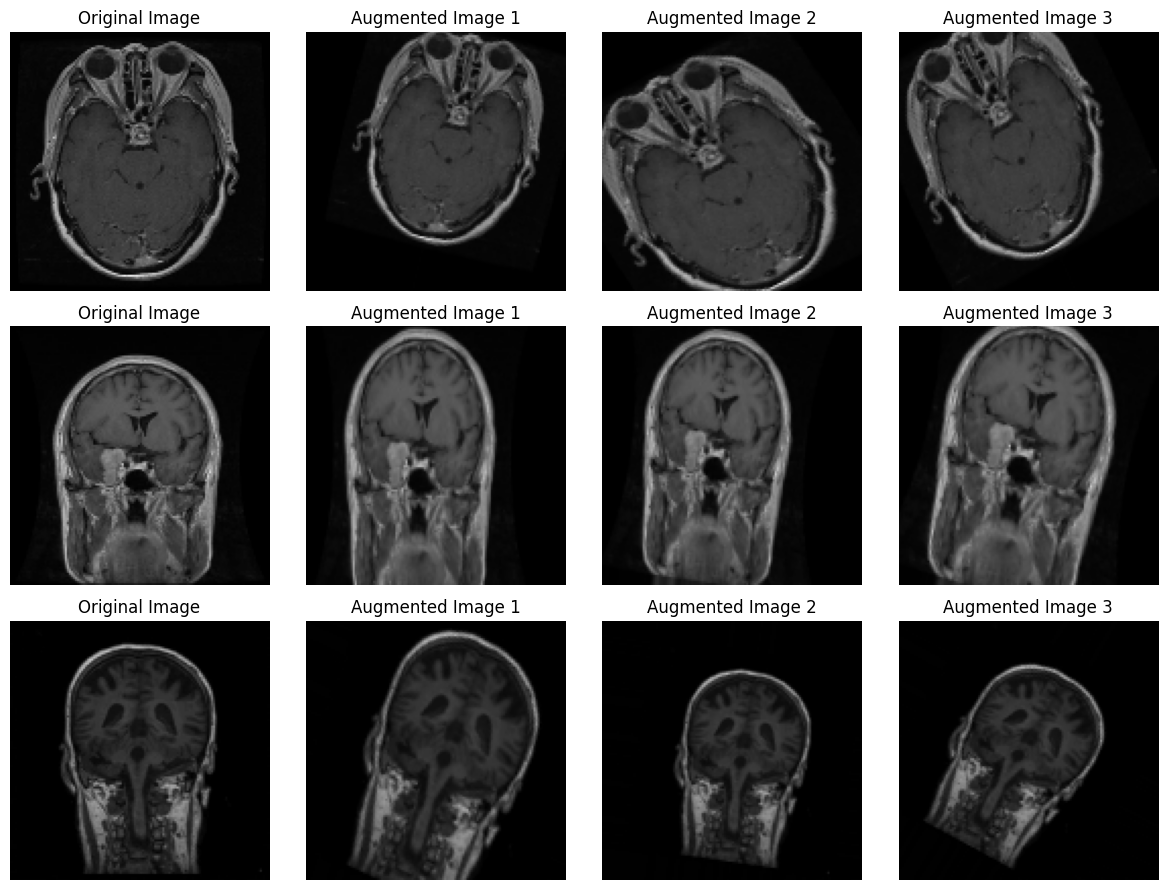

In [30]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:
        
        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')
            
    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

# Model with Data Augmentation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0014), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 128)     

In [32]:
start_time = time.time()

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    validation_data=(X_val, y_val),
                    epochs=100, verbose=1)

end_time = time.time()

runtime = end_time - start_time
print("Total runtime:", runtime, "seconds")

Epoch 1/100
164/164 [==============================] - 13s 69ms/step - loss: 11.7888 - accuracy: 0.3926 - val_loss: 1.5909 - val_accuracy: 0.3742
Epoch 2/100
164/164 [==============================] - 11s 65ms/step - loss: 1.3897 - accuracy: 0.4010 - val_loss: 2.5824 - val_accuracy: 0.2239
Epoch 3/100
164/164 [==============================] - 11s 67ms/step - loss: 1.3073 - accuracy: 0.4106 - val_loss: 1.3195 - val_accuracy: 0.4202
Epoch 4/100
164/164 [==============================] - 11s 66ms/step - loss: 1.3386 - accuracy: 0.4182 - val_loss: 1.2084 - val_accuracy: 0.3650
Epoch 5/100
164/164 [==============================] - 11s 66ms/step - loss: 1.2778 - accuracy: 0.3937 - val_loss: 1.0628 - val_accuracy: 0.5583
Epoch 6/100
164/164 [==============================] - 11s 66ms/step - loss: 1.2671 - accuracy: 0.4010 - val_loss: 1.0993 - val_accuracy: 0.5982
Epoch 7/100
164/164 [==============================] - 11s 66ms/step - loss: 1.2819 - accuracy: 0.3945 - val_loss: 1.2832 - val_a

# Confusion Matrix

82/82 [==============================] - 2s 20ms/step


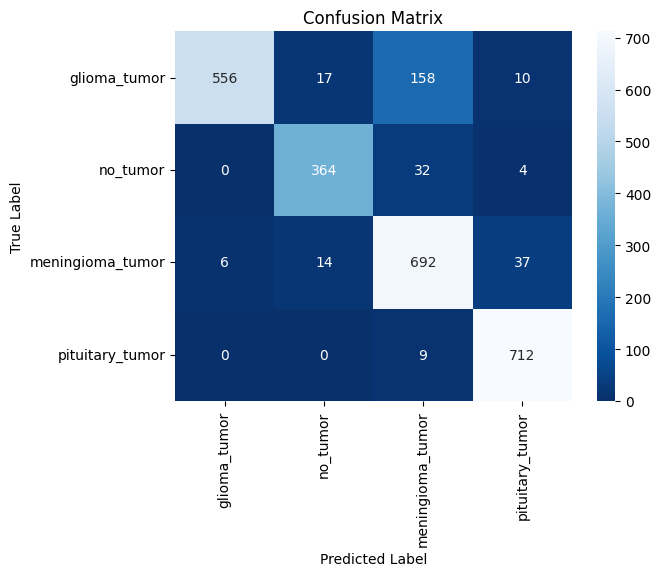

In [33]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(X_train), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

11/11 [==============================] - 0s 36ms/step


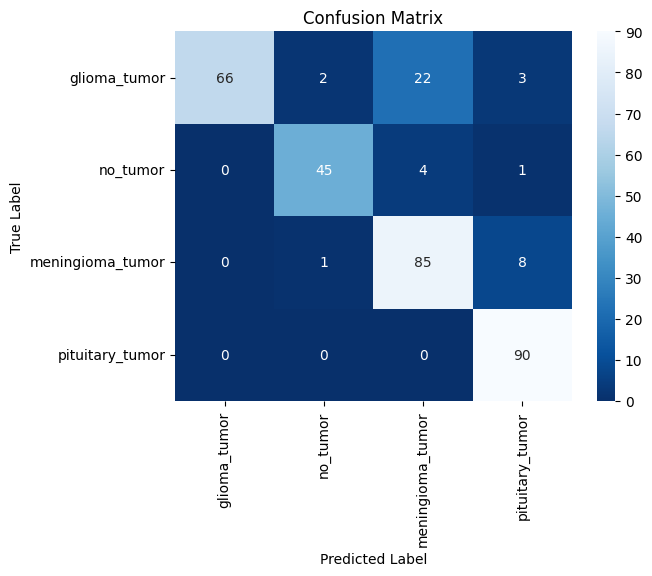

In [34]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


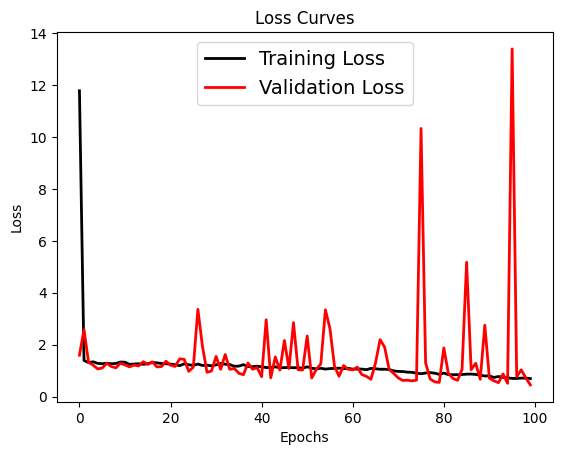

In [35]:
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14, loc='best')
plt.title('Loss Curves', fontsize=12)
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.show()

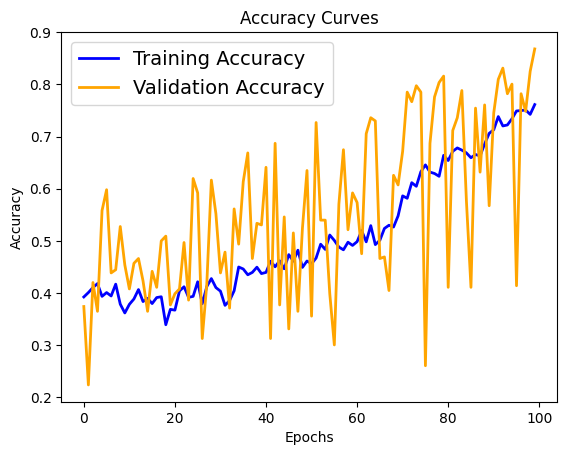

In [36]:
plt.plot(history.history['accuracy'], 'blue', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'orange', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14, loc='best')
plt.title('Accuracy Curves', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.show()

# Evaluation

**Here's an explanation of each metric in the classification report:**

<p>&nbsp;</p>

* **Precision**: Determines the accuracy of positive predictions by indicating how many of the predicted positive instances are actually positive.

* **Recall**: This metric measures the model's ability to correctly identify all relevant instances, indicating how many actual positive instances were correctly predicted.

* **F1-score**: Represents the harmonic mean of precision and recall, providing a balance between the two, which is especially useful when classes are imbalanced.

* **Support**: Indicates the number of actual occurrences of each class in the dataset, which provides context for calculating precision, recall, and F1 score.

* **Accuracy**: Indicates the overall correctness of the model's predictions by displaying the proportion of correctly predicted instances to the total number of instances.

* **Macro Avg**: Calculates the average precision, recall, and F1-score for all classes, treating each class equally regardless of class imbalance.

* **Weighted Avg**: Calculates the weighted average of precision, recall, and F1-score, with each class's score weighted by its support, providing a more accurate picture of overall model performance, particularly when classes are imbalanced.


In [37]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83        93
           1       0.94      0.90      0.92        50
           2       0.77      0.90      0.83        94
           3       0.88      1.00      0.94        90

    accuracy                           0.87       327
   macro avg       0.90      0.88      0.88       327
weighted avg       0.89      0.87      0.87       327



In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true_test, y_pred_test)
precision = precision_score(y_true_test, y_pred_test, average='weighted')
recall = recall_score(y_true_test, y_pred_test, average='weighted')
f1 = f1_score(y_true_test, y_pred_test, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.8746177370030581
Precision: 0.8907301121953037
Recall: 0.8746177370030581
F1-Score: 0.8729423058989151


<h1 style="font-family:verdana;"> <center>Thank you!</center> </h1>